# Relax Challenge

Relax Inc. is a highly funded startup based in San Francisco that makes productivity and project management software that's extremely popular with both individuals and teams. Founded in 2008 by several ex-Facebook employees, it's considered one of the sexiest companies to work for.

The data has the following two tables:

#### 1. A user table ("takehome_users") with data on 12,000 users who signed up for the product in the last two years. This table includes:

- name: the user's name
- object_id: the user's id
- email: email address
- creation_source: how their account was created. This takes on one of 5 values:
    - PERSONAL_PROJECTS: invited to join another user's personal workspace
    - GUEST_INVITE: invited to an organization as a guest (limited permissions)
    - ORG_INVITE: invited to an organization (as a full member)
    - SIGNUP: signed up via the website
    - SIGNUP_GOOGLE_AUTH: signed up using Google Authentication (using a Google email account for their login id)
- creation_time: when they created their account
- last_session_creation_time: unix timestamp of last login
- opted_in_to_mailing_list: whether they have opted into receiving marketing emails
- enabled_for_marketing_drip: whether they are on the regular marketing email drip
- org_id: the organization (group of users) they belong to
- invited_by_user_id: which user invited them to join (if applicable).

#### 2. A usage summary table ("takehome_user_engagement") that has a row for each day that a user logged into the product. 

## Objective: 
> Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven day period, identify which factors predict future user adoption.


In [1]:
import  sys
import pandas as pd
import numpy as np
import json
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import collections
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, make_scorer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score

% matplotlib inline

plt.style.use('ggplot')

In [2]:
#
# Read in the takehome_users data
#
user_df = pd.read_csv("takehome_users.csv", encoding="ISO-8859-1")

#
# Print the info.
#
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


> Columns 'last_session_creation_time' and 'invited_by_user_id' are missing alot of values.

In [3]:
#
# Print the head.
#
user_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
#
# Convert dates.
#
user_df['creation_time'] = pd.to_datetime(user_df['creation_time'])
user_df['last_session_creation_time'] = pd.to_datetime(user_df['last_session_creation_time'], unit='s')
user_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0


In [5]:
#
# Deal with missing data.
#
user_df['invited_by_user_id'].fillna(0, inplace=True)
user_df['last_session_creation_time'].fillna(user_df['creation_time'], inplace=True)
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    12000 non-null datetime64[ns]
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            12000 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(4), object(3)
memory usage: 937.6+ KB


In [6]:
#
# Read in the user_enagagement data.
#
engage_df = pd.read_csv('takehome_user_engagement.csv', parse_dates=['time_stamp'])

#
# Print the info
#
engage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null datetime64[ns]
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [7]:
#
# Print the head.
#
engage_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [8]:
#
# Find the users who had no activity after initially signing up.
#
signup = len(user_df.object_id.unique())
atleastone = len(engage_df.user_id.unique())
user_df['atLeastOnce'] = (pd.to_datetime(user_df['last_session_creation_time'] - user_df['creation_time']) > pd.to_datetime('0', unit='s')).astype(int)
user_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,atLeastOnce
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,1
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,1


[Text(0,0,'ORG_INVITE'),
 Text(0,0,'GUEST_INVITE'),
 Text(0,0,'PERSONAL_PROJECTS'),
 Text(0,0,'SIGNUP'),
 Text(0,0,'SIGNUP_GOOGLE_AUTH')]

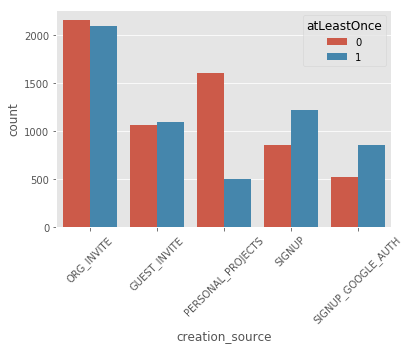

In [9]:
#
# Look at the method of signup compared to if the user had logged in at least once after account creation.
#
order = ['ORG_INVITE', 'GUEST_INVITE', 'PERSONAL_PROJECTS', 'SIGNUP', 'SIGNUP_GOOGLE_AUTH']
p = sns.countplot(x='creation_source', data=user_df, hue='atLeastOnce', order=order)
labels = p.get_xticklabels()
p.set_xticklabels(labels, rotation=45)

> Looks like person projects had the highest rate of users who signed up but never logged in again.

### Identify adopted users.

In [10]:
#
# Create a dictionary to save the adopted users data.  Initialize all user ids to False.
#
adopted = {x:0 for x in range(1, len(user_df)+1)}

#
# Loop through the user engagments.
#
for user in engage_df.groupby('user_id'):
    #
    # Obtain all login times for the user.
    #
    time_stamps = user[1]['time_stamp'].sort_values().reset_index(drop=True)
    
    #
    # Get the user id and total number of logins.
    #
    uid, total_logins = user[0], len(time_stamps)
    
    #
    # Remove users with less than 3 logins.
    #
    if total_logins < 3:
        continue
    
    #
    # Examine the data in a 7 day window.
    #
    for i, time in enumerate(time_stamps):
        #
        # Only need to look at 3 logins.
        #
        if i == total_logins - 2:
            break  
            
        #
        # Define the end time.
        #
        end = time + pd.Timedelta('7D')
        
        #
        # Look at the next 2 login times.
        #
        next1 = time_stamps[i + 1]
        next2 = time_stamps[i + 2]
        
        #
        # If the next 2 logins are within the window, identify the user as 'adopted'
        #
        if (next1 < end) & (next2 < end):
            adopted[uid] = 1
            break    

In [11]:
#
# Create a dataframe from the adpoted dict.
#
adopted_df = pd.DataFrame.from_dict(adopted, orient='index').reset_index()
adopted_df.columns = ['user_id', 'adopted']
adopted_df.head()

,user_id,adopted
0,1,0
1,2,1
2,3,0
3,4,0
4,5,0


In [12]:
#
# Save into user dataframe.
#
user_df['adopted'] = adopted_df['adopted']

[Text(0,0,'ORG_INVITE'),
 Text(0,0,'GUEST_INVITE'),
 Text(0,0,'PERSONAL_PROJECTS'),
 Text(0,0,'SIGNUP'),
 Text(0,0,'SIGNUP_GOOGLE_AUTH')]

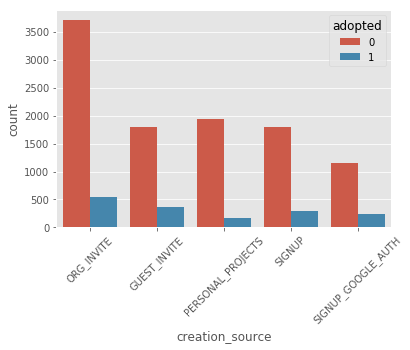

In [13]:
#
# Look at the method of signup compared to if the user was identified as 'adopted'.
#
order = ['ORG_INVITE', 'GUEST_INVITE', 'PERSONAL_PROJECTS', 'SIGNUP', 'SIGNUP_GOOGLE_AUTH']
p = sns.countplot(x='creation_source', data=user_df, hue='adopted', order=order)
labels = p.get_xticklabels()
p.set_xticklabels(labels, rotation=45)

> Appears to be a fairly even split.

[Text(0,0,'0'), Text(0,0,'1')]

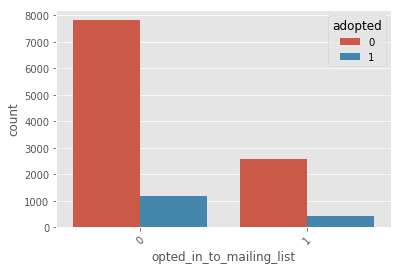

In [14]:
p = sns.countplot(x='opted_in_to_mailing_list', data=user_df, hue='adopted')
labels = p.get_xticklabels()
p.set_xticklabels(labels, rotation=45)

[Text(0,0,'0'), Text(0,0,'1')]

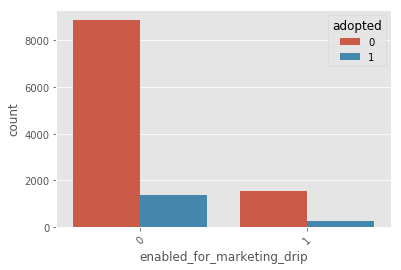

In [15]:
p = sns.countplot(x='enabled_for_marketing_drip', data=user_df, hue='adopted')
labels = p.get_xticklabels()
p.set_xticklabels(labels, rotation=45)

> Nothing really exciting here.

### Build a model to determine important features.

In [16]:
#
# Prepare date by dropping columns we dont need.
#
model_df = pd.DataFrame(user_df.drop(['name','email','invited_by_user_id','object_id'], axis=1))

#
# Rotate creation source to columns.
#
model_df.rename(columns={'creation_source':'cs'}, inplace=True)
model_df = pd.get_dummies(model_df, columns=['cs'], drop_first=True)

#
# Extract the month and day of the creation and last session.
#
for col in ['last_session_creation_time','creation_time']:
    model_df["month_" + col] = model_df[col].dt.month
    model_df["day_" + col] = model_df[col].dt.day
    
#
# Drop the creation and last login columns.
#
model_df.drop('creation_time',  axis=1, inplace=True)
model_df.drop('last_session_creation_time',  axis=1, inplace=True)

#
# Print the head.
#
model_df.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,atLeastOnce,adopted,cs_ORG_INVITE,cs_PERSONAL_PROJECTS,cs_SIGNUP,cs_SIGNUP_GOOGLE_AUTH,month_last_session_creation_time,day_last_session_creation_time,month_creation_time,day_creation_time
0,1,0,11,0,0,0,0,0,0,4,22,4,22
1,0,0,1,1,1,1,0,0,0,3,31,11,15
2,0,0,94,0,0,1,0,0,0,3,19,3,19
3,0,0,1,1,0,0,0,0,0,5,22,5,21
4,0,0,193,1,0,0,0,0,0,1,22,1,17


In [17]:
#
# Save the adopted column as the target and drop from the mode dataframe.
#
target = model_df['adopted']
model_df.drop('adopted',  axis=1, inplace=True)

In [18]:
#
# Split into train/test using an 80/20 split.
#
X_train, X_test, y_train, y_test = train_test_split(model_df, target, test_size=0.2, random_state=42, stratify=target)

In [19]:
#
# Five fold, cross validation.
#
CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#
# Define the metric for model evaluation.
#
model_metric = make_scorer(roc_auc_score, greater_is_better=True)

In [20]:
#
# Initialize the Random Forest Classifier
#
RF = RandomForestClassifier(n_jobs=-1)

#
# Define the gridsearch.
#
param_grid = {'n_estimators' : [40, 60, 80], 
              'min_samples_split' : [4, 6, 8], 
              'max_depth' : [3, 6, 10], 
              'class_weight' : ['balanced']
             }

#
# Run the grid search.
#
RF_CV = GridSearchCV(RF, param_grid, cv=CV, scoring=model_metric, verbose=1)

In [21]:
#
# Fit the model.
#
RF_CV.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:   50.6s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [40, 60, 80], 'min_samples_split': [4, 6, 8], 'max_depth': [3, 6, 10], 'class_weight': ['balanced']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(roc_auc_score), verbose=1)

In [22]:
#
# Print out the best score.
#
print("Score ", RF_CV.best_score_)
print("Params ", RF_CV.best_params_)

Score  0.930568255082321
Params  {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 8, 'n_estimators': 40}


In [23]:
#
# Use the best parameters learned from Gridsearch in the RF Classifier.
#
RF_best = RandomForestClassifier(class_weight= RF_CV.best_params_['class_weight'], n_jobs=-1, 
                                 min_samples_split=RF_CV.best_params_['min_samples_split'], 
                                 max_depth=RF_CV.best_params_['max_depth'],
                                 n_estimators=RF_CV.best_params_['n_estimators'])

#
# Fit the model
#
RF_best.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=8, min_weight_fraction_leaf=0.0,
            n_estimators=40, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

### Use the model for prediction

In [26]:
#
# Prediction
#
pred_prob = RF_best.predict_proba(X_test)[:,1]
print(roc_auc_score(y_test, pred_prob))
cv_score = cross_val_score(RF_best, X_test, y_test, cv=CV, scoring=model_metric)
print(cv_score)

0.9865985576923078
[0.87740385 0.91766827 0.97115385 0.91466346 0.89302885]


In [27]:
#
# What were the most important features?
#
print(pd.DataFrame(RF_best.feature_importances_, index = X_train.columns,
                   columns=['importance']).sort_values('importance', ascending=False))

                                  importance
atLeastOnce                         0.345038
month_last_session_creation_time    0.289613
month_creation_time                 0.131988
day_last_session_creation_time      0.119426
day_creation_time                   0.060510
org_id                              0.032598
cs_PERSONAL_PROJECTS                0.005258
opted_in_to_mailing_list            0.003469
cs_ORG_INVITE                       0.003390
cs_SIGNUP                           0.003112
cs_SIGNUP_GOOGLE_AUTH               0.002840
enabled_for_marketing_drip          0.002758


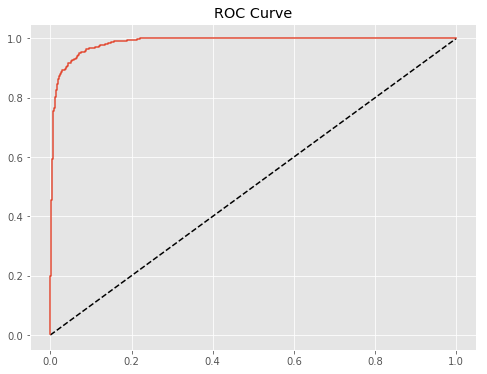

In [28]:
#
# Compute Receiver operating characteristic.
#
fpr, tpr, thresholds = roc_curve(y_test, pred_prob)

#
# Visualize the ROC Curve
#
plt.plot([0, 1], [0, 1], 'k--')
plt.gcf().set_size_inches(8,6)
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.show()

# Summary

The feature importance table shows that if the user logging in at least once had the most weight on whether that user would be adpoted.  This makes a lot of sense.  Soemthing else interesting about the feature table is that month and day the account was created had a fairly large impact as well as the org_id that referred the user to the site. 